In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import pandas as pd
import wandb
from scipy import interpolate
import seaborn as sns

In [2]:
sns.set()
# sns.set(font_scale = 2)
# make sns markers bigger
# sns.set_style("whitegrid", {'axes.linewidth': 2.5})
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# Set plt settings for a better looking plot
# plt.rcParams["figure.figsize"] = (10, 6)
# plt.rcParams["font.size"] = 16
# plt.rcParams["axes.titlesize"] = 20
# plt.rcParams["axes.labelsize"] = 18
# plt.rcParams["xtick.labelsize"] = 16
# plt.rcParams["ytick.labelsize"] = 16
# plt.rcParams["legend.fontsize"] = 16
# plt.rcParams["lines.linewidth"] = 2
# plt.rcParams["lines.markersize"] = 10
# plt.rcParams["lines.markeredgewidth"] = 2
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
def get_data(entity, project, jobs=None):
    api = wandb.Api()
    runs = api.runs(entity + "/" + project)
    if jobs is not None:
        runs = [r for r in runs if "job" in r.config and int(r.config["job"]) in jobs]

    data = {}
    for r in runs:
        p = r.config["problem"]
        n = r.config["noise"]
        g = f"{p}_{n*100}"
        a = r.config["algo"]
        if g not in data:
            data[g] = {}
        if a not in data[g]:
            data[g][a] = []
        data[g][a].append(r)
    return data

In [23]:
class GroupedRun:
    def __init__(self, algo, runs):
        self.algo = algo
        self.runs = runs
        self.interpolators = {}
        self.ranges = {}

    # length
    def __len__(self):
        return len(self.runs)

    def interpolate(self, y):
        if y not in self.interpolators:
            self.interpolators[y] = []
            self.ranges[y] = (- np.inf, max_evals)
        for r in self.runs:
            h = r.history()
            i = interpolate.interp1d(h["evaluations"], h[y])
            self.interpolators[y].append(i)
            self.ranges[y] = (max(self.ranges[y][0], h["evaluations"].min()), min(self.ranges[y][1], h["evaluations"].max()))

    def compute(self, field, x):
        # filter x for range
        x = [x[i] for i in range(len(x)) if self.ranges[field][0] <= x[i] <= self.ranges[field][1]]
        y = []
        for i in self.interpolators[field]:
            y.append(i(x))
        return np.array(x), np.array(y)

    def get_mean_std(self, field, x):
        x, y = self.compute(field, x)
        return np.mean(y, axis=0), np.std(y, axis=0)

    def has_field(self, field):
        # check if runs have field
        for r in self.runs:
            if field not in r.history():
                return False
        return True

    def get_field(self, field):
        # get runs field
        y = []
        for r in self.runs:
            for _ in range(10):
                try:
                    h = r.history()
                    y.append(h[field].iloc[-1])
                    break
                except:
                    pass
        return np.array(y)

In [24]:
entity = "sureli"
project = "lucie-robot"
# jobs = None
jobs = [10000, 10100, 10101]
max_evals = 20000

colors = {
    "UCEA":"blue",
    "EA":"red",
    "MultiEA":"green",
}
markers =  {
    "UCEA":"^",
    "EA":"o",
    "MultiEA":"s",
}
rename = {
    "UCEA":"LUCIE",
    "MultiEA":"Resample",
    # EA becomes "mu plus lambda" in greek letters
    "EA": r"$\mu + \lambda$",
}

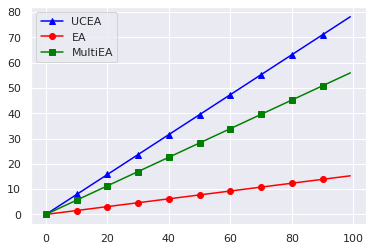

In [25]:
for a in colors.keys():
    x = range(100)
    y = np.array(x) * np.random.random()
    plt.plot(x, y, color=colors[a], label=a, marker=markers[a], markevery=10)
plt.legend()

In [26]:
games = get_data(entity, project, jobs)

In [27]:
len(games)

2

cartpole_400 UCEA fitness 15
cartpole_400 MultiEA fitness 15
cartpole_400 EA fitness 15


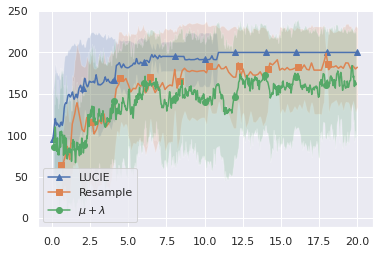

cartpole_800 UCEA fitness 10
cartpole_800 MultiEA fitness 10
cartpole_800 EA fitness 10


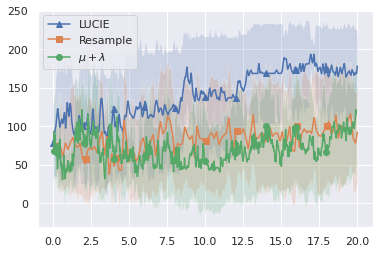

In [ ]:
for g, runs in games.items():
    y = "fitness"
    for a, r in runs.items():
        # Fitness plot
        group = GroupedRun(a, r)
        print(f"{g} {a} {y} {len(group)}")
        if not group.has_field(y):
            continue
        group.interpolate(y)
        mean, std = group.get_mean_std(y, np.arange(group.ranges[y][0], group.ranges[y][1]))
        # Use LUCIE instead of UCEA as label
        
        label = rename[a] if a in rename else a
        X = np.arange(group.ranges[y][0], group.ranges[y][1]) / 1000
        plt.plot(
            X,
            mean, 
            label=label,
            # color=colors[a],
            marker=markers[a],
            markevery=len(mean) // 10,
            )
        plt.fill_between(X, mean - std, mean + std, alpha=0.2)
    plt.legend()
    # plt.title(f"{g}")
    # save figure without borders
    plt.savefig(f"paper_figures/{g}_{y}.png", bbox_inches="tight")
    plt.show()



In [ ]:
"final validation fitness"

['UCEA', 'MultiEA', 'EA']
cartpole_400 EA 15
15 155.0
cartpole_400 MultiEA 15
15 179.8
cartpole_400 UCEA 15
15 200.0


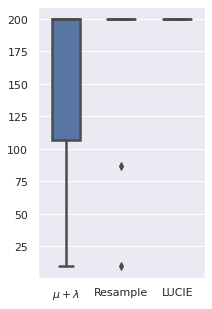

['UCEA', 'MultiEA', 'EA']
cartpole_800 EA 10
10 89.4
cartpole_800 MultiEA 10
10 62.7
cartpole_800 UCEA 10
10 179.4


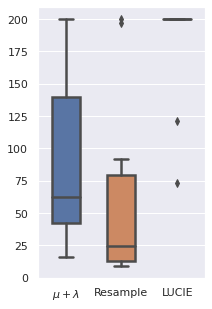

In [61]:
sns.set(rc={'figure.figsize':(3, 5)})

boxplot_order = ["EA", "MultiEA", "UCEA"]
# boxplot_order = ['UCEA', 'MultiEA', 'EA']
for g, runs in games.items():
    data = []
    # boxplot_order = list(runs.keys())
    print(list(runs.keys()))
    fig, ax = plt.subplots()
    for a in boxplot_order:
        r = runs[a]
        # Fitness plot
        group = GroupedRun(a, r)
        print(f"{g} {a} {len(group)}")
        val = group.get_field(field="final validation fitness")
        # print(val)
        print(len(val), np.mean(val))
        data.append(val)
    sns.boxplot(
            data=data,
            linewidth=2.5,
            width=0.5,
        )
    # set labels 
    ax.set_xticklabels([rename[a] for a in boxplot_order])
    # smaller width
    # ax.tick_params(axis="x", which="major", width=1)

    plt.savefig(f"paper_figures/boxplot_{g}.png", bbox_inches="tight")
    plt.show()

In [49]:
list(runs.keys())

['UCEA', 'MultiEA', 'EA']